In [2]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import json
from glob import glob
from skimage.segmentation import slic
from sklearn.linear_model import LinearRegression



# Load the pre-trained ResNet18 model
model = models.resnet18(pretrained=True)
model.eval()  # Set model to evaluation mode

# Define the image preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

with open("imagenet_class_index.json") as f:
    class_idx = json.load(f)
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
idx2synset = [class_idx[str(k)][0] for k in range(len(class_idx))]
id2label = {v[0]: v[1] for v in class_idx.values()}

imagenet_path = './imagenet_samples'

# List of image file paths
image_paths =  [f for f in os.listdir(imagenet_path) if os.path.isfile(os.path.join(imagenet_path, f))]

# print("ImagePaths: ", image_paths)






/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
for img_path in image_paths:
    # Open and preprocess the image
    my_img = os.path.join(imagenet_path, img_path)
    input_image = Image.open(my_img).convert('RGB')
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

    # Move the input and model to GPU if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    # Perform inference
    with torch.no_grad():
        output = model(input_batch)

    # Get the predicted class index
    _, predicted_idx = torch.max(output, 1)
    predicted_idx = predicted_idx.item()
    predicted_synset = idx2synset[predicted_idx]
    predicted_label = idx2label[predicted_idx]

    print(f"Predicted label: {predicted_synset} ({predicted_label})")

Predicted label: n03250847 (drumstick)
Predicted label: n04118776 (rule)
Predicted label: n01806143 (peacock)
Predicted label: n03792782 (mountain_bike)
Predicted label: n03938244 (pillow)


**Question 1**

Get all the images


In [4]:
images = []
for img_path in image_paths:

    my_img = os.path.join(imagenet_path, img_path)
    input_image = Image.open(my_img).convert('RGB')
    input_tensor = preprocess(input_image)
    images.append((input_tensor, input_image))


LIME

In [17]:

def generate_perturbations(n_superpixels, n_samples=1000):
    perturbations = np.random.randint(0, 2, (n_samples, n_superpixels))
    perturbations[0, :] = 1
    return perturbations


def apply_perturbation(input_image, segments, mask):
    perturbed_image = input_image.clone()
    segments_tensor = torch.tensor(segments, device=perturbed_image.device)
    for i in range(len(mask)):
        if mask[i] == 0:
            region_mask = (segments_tensor == i)
            region_mask = region_mask.unsqueeze(0).expand_as(perturbed_image)
            perturbed_image[region_mask] = perturbed_image[region_mask].mean()
    return perturbed_image



def get_predictions(input_tensor, perturbations, segments, predicted_idx):
    predictions = []
    for mask in perturbations:
        perturbed_image = apply_perturbation(input_tensor, segments, mask)
        perturbed_image = perturbed_image.unsqueeze(0).to(input_tensor.device)
        with torch.no_grad():
            output = model(perturbed_image)
        prob = torch.softmax(output, dim=1)[0, predicted_idx].item()
        predictions.append(prob)
    return np.array(predictions)





def lime_explanation(input_tensor, model, predicted_idx, num_samples=1000, n_segments=50, kernel_width=0.25):
    image_np = input_tensor.detach().permute(1, 2, 0).cpu().numpy()
    if isinstance(image_np, torch.Tensor):
        image_np = image_np.permute(1, 2, 0).cpu().numpy()


    segments = slic(image_np, n_segments=n_segments, compactness=10, sigma=1)
    n_superpixels = np.unique(segments).shape[0]

    perturbations = generate_perturbations(n_superpixels, num_samples)
    predictions = get_predictions(input_tensor, perturbations, segments, predicted_idx)

    a = kernel_width * n_superpixels

    distances = np.sum(perturbations == 0, axis=1)
    weights = np.exp(-(distances**2) / a**2)

    clf = LinearRegression()
    clf.fit(perturbations, predictions, sample_weight=weights)

    importance_map = np.zeros_like(segments, dtype=float)
    for i in range(n_superpixels):
        importance_map[segments == i] = clf.coef_[i]




    return importance_map,segments



lime_explanations = []
for input_tensor, original_image in images:
    input_tensor = input_tensor.to(input_batch.device)
    explanation = lime_explanation(input_tensor, model, predicted_idx)
    lime_explanations.append(explanation)

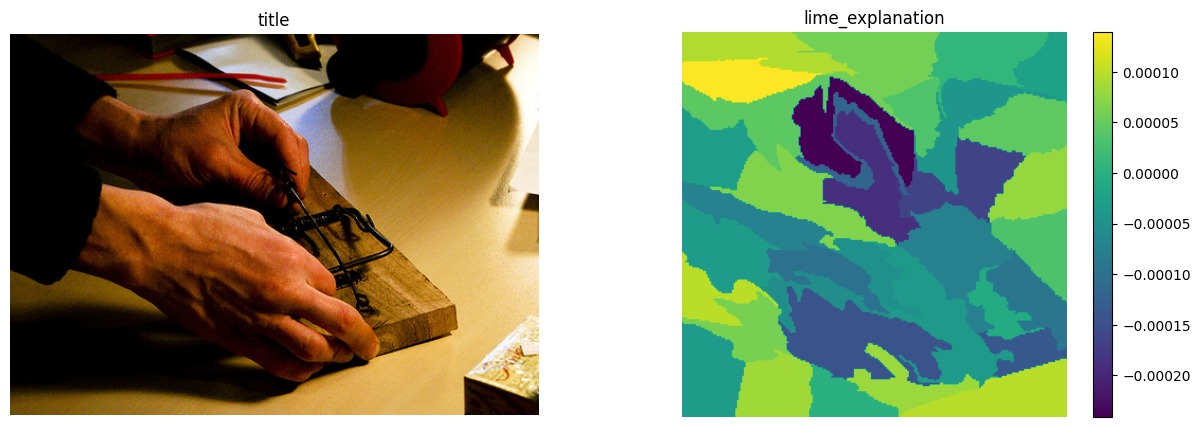

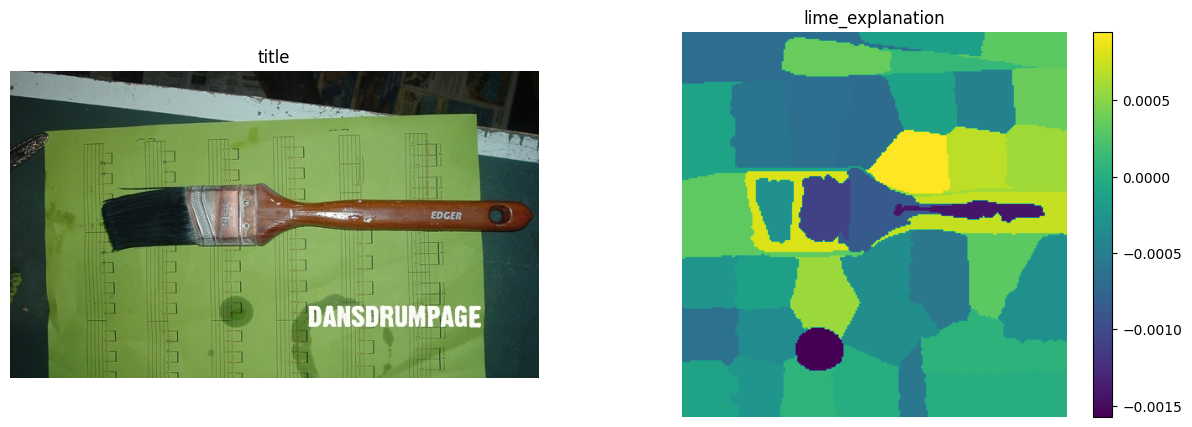

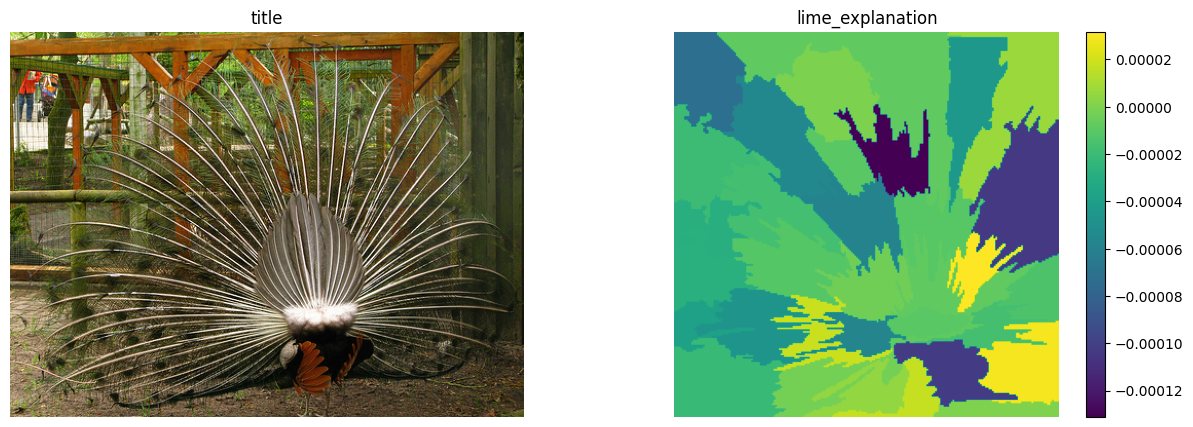

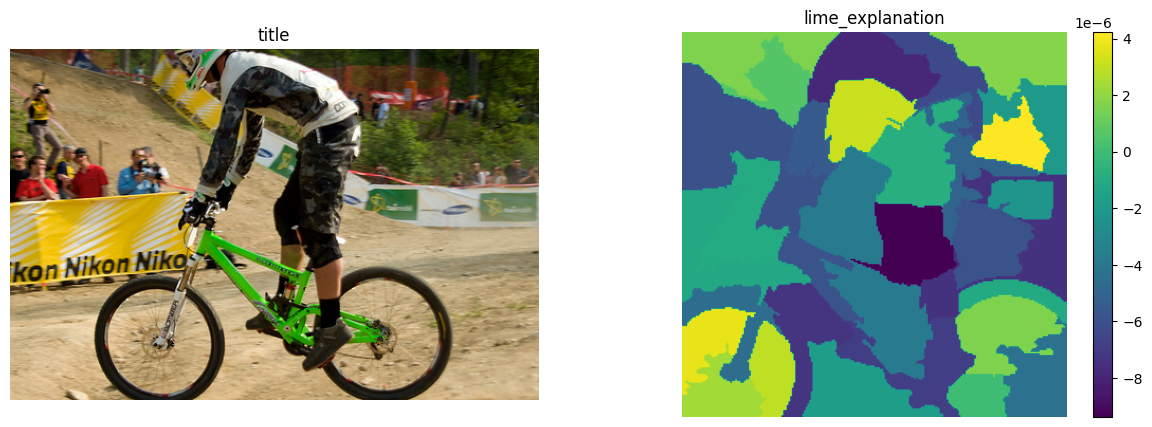

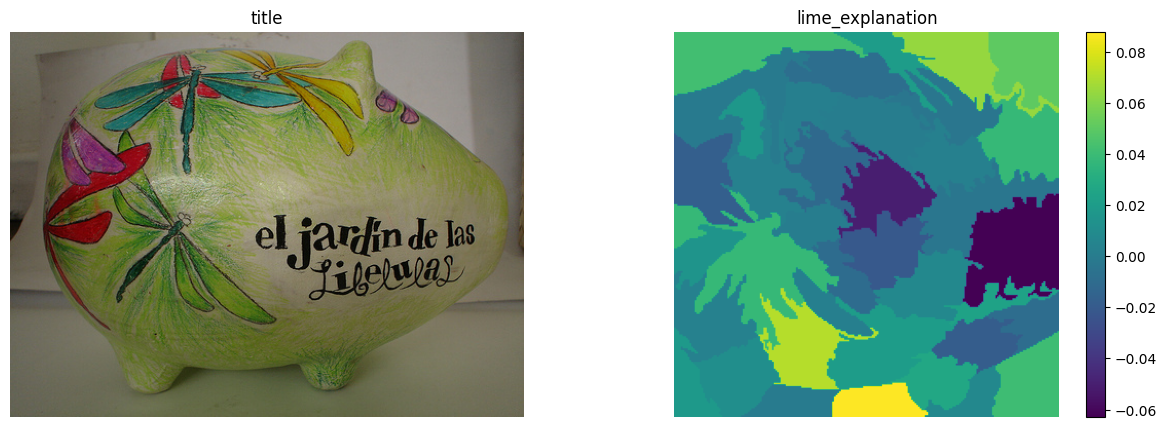

In [18]:
from skimage.segmentation import mark_boundaries
for idx, (input_tensor, original_image) in enumerate(images):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('title')
    plt.axis('off')



    plt.subplot(1, 2, 2)


    a,segments = lime_explanations[idx]
    plt.imshow(mark_boundaries(a, segments))
    plt.imshow(a)
    plt.title('lime_explanation')
    plt.axis('off')
    plt.colorbar()
    plt.show()

100%|██████████| 50/50 [00:22<00:00,  2.18it/s]


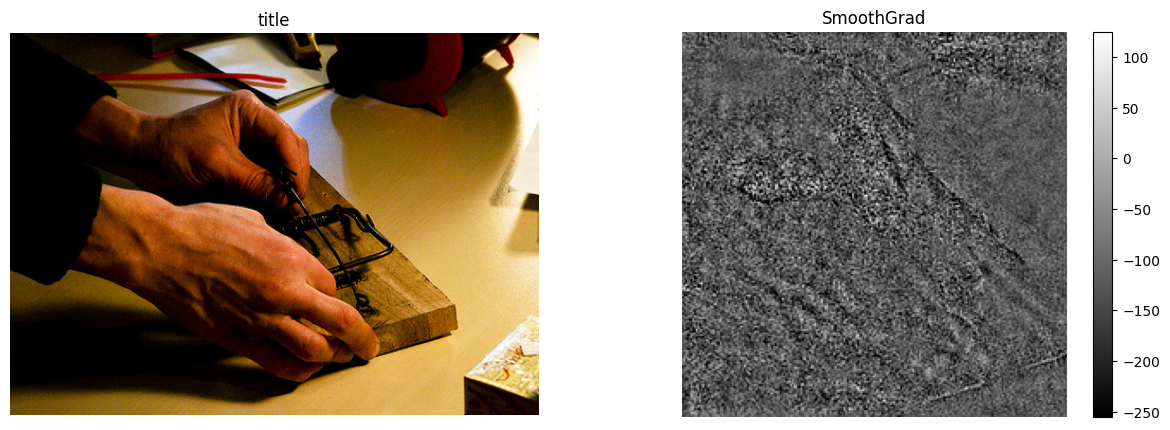

100%|██████████| 50/50 [00:17<00:00,  2.88it/s]


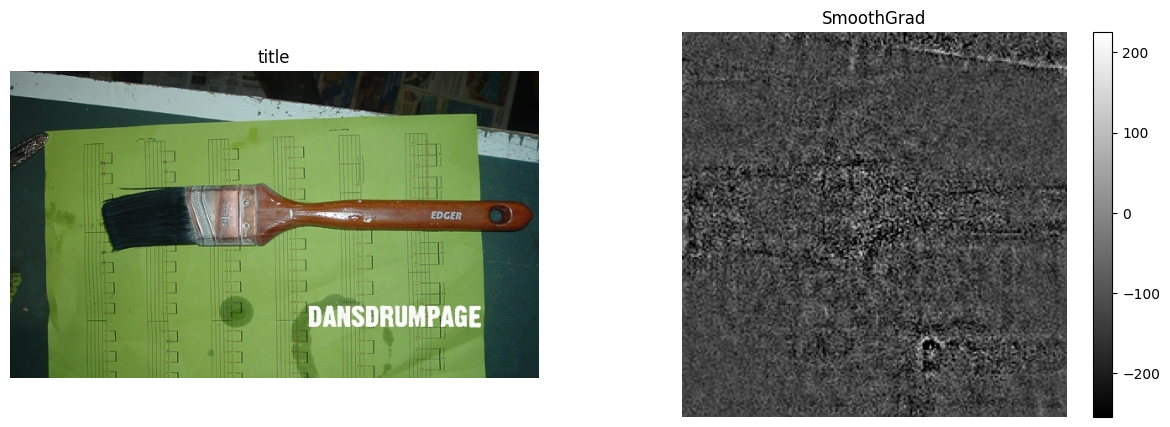

100%|██████████| 50/50 [00:18<00:00,  2.65it/s]


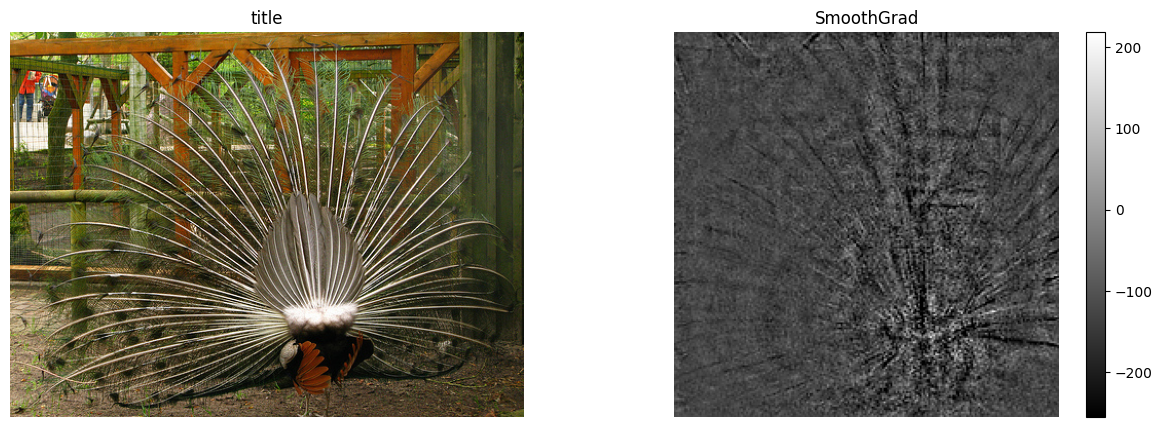

100%|██████████| 50/50 [00:17<00:00,  2.82it/s]


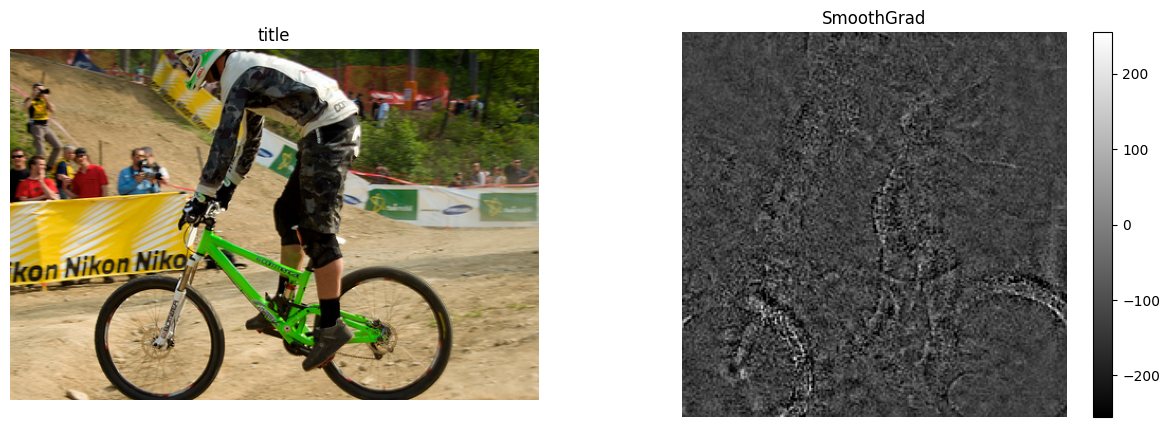

100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


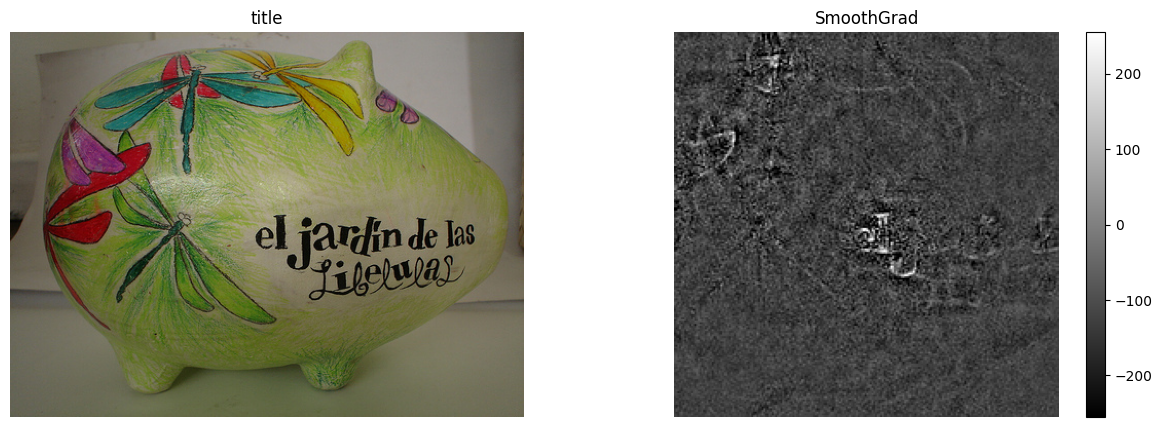

In [5]:
from tqdm import tqdm

def smoothgrad(image_tensor, model, preprocess, num_samples=50):



    smooth_grad = torch.zeros_like(image_tensor)
    noise_level = 0.25 * (input_tensor.max() - input_tensor.min())
    for _ in tqdm(range(num_samples)):
        noise = torch.randn_like(image_tensor) * noise_level
        noisy_input = image_tensor + noise
        noisy_input = torch.clamp(noisy_input, 0, 1)
        noisy_input.requires_grad_()

        output = model(noisy_input)
        class_idx = output.argmax(dim=1).item()
        model.zero_grad()

        output[0, class_idx].backward()

        smooth_grad += noisy_input.grad.data.cpu().numpy()

    smooth_grad = smooth_grad[0, :, :, :]  / num_samples

    img_2d = np.sum(smooth_grad.cpu().detach().numpy(), axis=0)
    span = abs(np.percentile(img_2d, 99))
    img_2d = np.clip(-(img_2d + span) / (2 * span), -1, 1) * 255


    return img_2d

# Apply SmoothGrad on a sample image
i = 0
for idx, (input_tensor, original_image) in enumerate(images):

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('title')
    plt.axis('off')



    plt.subplot(1, 2, 2)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_tensor = input_tensor.unsqueeze(0)
    input_tensor = input_tensor.to(device)
    input_batch = input_tensor.unsqueeze(0).to(device)
    smooth_grad_exp = smoothgrad(input_tensor, model, preprocess)
    plt.imshow(smooth_grad_exp,cmap='gray')
    plt.title('SmoothGrad')
    plt.axis('off')
    plt.colorbar()
    plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

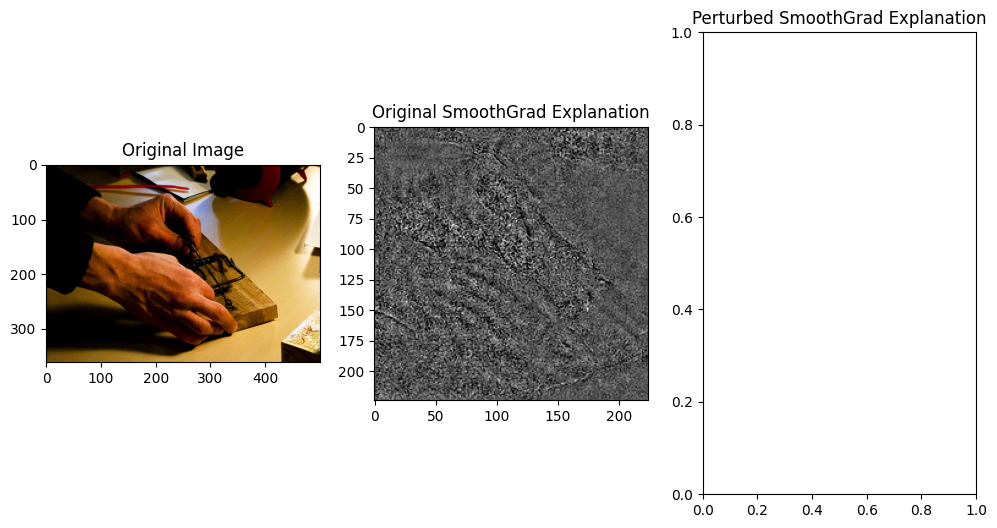

In [6]:
# def pgd_attack(image, model, preprocess, epsilon, alpha=2/255, num_steps=10, lambda_weight=0.5):

#     original_explanation = smoothgrad(image, model, preprocess)


#     perturbed_image = image.clone()


#     for step in range(num_steps):
#         perturbed_explanation = smoothgrad(perturbed_image, model, preprocess)

#         explanation_loss = -torch.nn.functional.mse_loss(
#             torch.tensor(perturbed_explanation, device=perturbed_image.device),
#             torch.tensor(original_explanation, device=perturbed_image.device)
#         )


#         output = model(perturbed_image)
#         target_class = output.argmax(dim=1)
#         prediction_loss = torch.nn.CrossEntropyLoss()(output, target_class)


#         attack_loss = explanation_loss + lambda_weight * prediction_loss

#         model.zero_grad()
#         attack_loss.backward()


#         perturbed_image = perturbed_image + alpha * attack_loss
#         perturbed_image = torch.clamp(perturbed_image, image - epsilon, image + epsilon)
#         perturbed_image = torch.clamp(perturbed_image, 0, 1)



#     final_explanation = smoothgrad(perturbed_image, model, preprocess)

#     return perturbed_image.detach().cpu().numpy(), final_explanation





# for idx, (input_tensor, original_image) in enumerate(images):

#   input_tensor = input_tensor.unsqueeze(0)
#   input_tensor = input_tensor.to(device)
#   plt.figure(figsize=(12, 6))
#   plt.subplot(1, 3, 1)
#   plt.title("Original Image")
#   plt.imshow(original_image)

#   original_explanation = smoothgrad(input_tensor, model, preprocess)
#   plt.subplot(1, 3, 2)
#   plt.title("Original SmoothGrad Explanation")
#   plt.imshow(original_explanation, cmap='gray')

#   plt.subplot(1, 3, 3)
#   plt.title("Perturbed SmoothGrad Explanation")
#   perturbed_img, perturbed_explanation = pgd_attack(
#     input_tensor, model, preprocess, 8/255, alpha=2/255, num_steps=5
# )

#   plt.imshow(perturbed_explanation, cmap='gray')

#   plt.tight_layout()
#   plt.show()

